In [1]:
import numpy as np
import scipy
import re
import collections
from collections import defaultdict
import datetime
import time
import random


import matplotlib.pyplot as plt
%matplotlib inline


import spacy
from spacy.symbols import ORTH
!python -m spacy download en
from spacy.tokenizer import Tokenizer
from spacy.lang.en import English

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, ToktokTokenizer, RegexpTokenizer

import gensim
from gensim import models
from gensim import corpora

from sklearn.datasets import fetch_20newsgroups
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

import torch
from torch import nn
from torch.nn import functional as F
from torch import optim
from torch.utils.data import Dataset, DataLoader

[!] As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use the full
pipeline package name 'en_core_web_sm' instead.
[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


2022-04-06 23:22:51.360564: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-04-06 23:22:51.360777: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[nltk_data] Downloading package stopwords to C:\Users\El
[nltk_data]     Tuko\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Preprocessing and tokenizing

In [2]:
train_source = fetch_20newsgroups(subset='train')
test_source = fetch_20newsgroups(subset='test')

print('Количество обучающих текстов', len(train_source['data']))
print('Количество тестовых текстов', len(test_source['data']))

print()
print(train_source['data'][0].strip())


print()
print('Метка', train_source['target'][0])

Количество обучающих текстов 11314
Количество тестовых текстов 7532

From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----

Метка 7


In [3]:
def preprocess(corpus, whitespaces=True, punctuation=True, numbers=True):
    corpus = re.sub(r"[^a-zA-Z0-9.?! ]+", " ", corpus.lower().strip()) 
    if whitespaces == True:
        corpus = re.sub(r"[' ']{2,}", " ", corpus)
    if punctuation == True:
        corpus = re.sub(r"[,.!?:;%]+", " ", corpus)
    if numbers == True:
        corpus = re.sub(r"[0-9]+", "", corpus)        
    return corpus

In [4]:
sum_of_len = 0
for idx, sentence in enumerate(train_source['data']):
    sum_of_len += len(preprocess(train_source['data'][idx]))
sum_of_len/idx

1695.4272076372315

In [5]:
train_source['data'][0]

"From: lerxst@wam.umd.edu (where's my thing)\nSubject: WHAT car is this!?\nNntp-Posting-Host: rac3.wam.umd.edu\nOrganization: University of Maryland, College Park\nLines: 15\n\n I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was a 2-door sports car, looked to be from the late 60s/\nearly 70s. It was called a Bricklin. The doors were really small. In addition,\nthe front bumper was separate from the rest of the body. This is \nall I know. If anyone can tellme a model name, engine specs, years\nof production, where this car is made, history, or whatever info you\nhave on this funky looking car, please e-mail.\n\nThanks,\n- IL\n   ---- brought to you by your neighborhood Lerxst ----\n\n\n\n\n"

In [6]:
# initializing spacy tokenizer adding stopwords from nltk
nlp = English()
nlp.Defaults.stop_words |= set(stopwords.words('english')) - set(nlp.Defaults.stop_words)
tokenizer = Tokenizer(nlp.vocab)

In [7]:
# preprocessing and following tokenization 
train_tokens = [list(map(str, tokenizer(preprocess(sentence)))) for sentence in train_source['data']]
test_tokens = [list(map(str, tokenizer(preprocess(sentence)))) for sentence in test_source['data']]

In [8]:
# initializing sklearn TfidfVectorizer
max_df = 0.80
min_df = 0.01
counter = CountVectorizer(preprocessor=preprocess, max_df=max_df, 
                             min_df=min_df)

In [9]:
counter.fit_transform(train_source['data']+test_source['data'])
vocab = counter.vocabulary_
vectorizer = TfidfVectorizer(preprocessor=preprocess, max_df=max_df, 
                             min_df=min_df, vocabulary=vocab)

In [10]:
# tfidf transform
train_vectors = vectorizer.fit_transform(train_source['data'])
test_vectors = vectorizer.fit_transform(test_source['data'])

In [11]:
print('Размерность матрицы признаков обучающей выборки', train_vectors.shape)
print('Размерность матрицы признаков тестовой выборки', test_vectors.shape)
print()
print('Количество ненулевых элементов в обучающей выборке', train_vectors.nnz)
print('Процент заполненности матрицы признаков {:.2f}%'.format(train_vectors.nnz * 100 / (train_vectors.shape[0] * train_vectors.shape[1])))
print()
print('Количество ненулевых элементов в тестовой выборке', test_vectors.nnz)
print('Процент заполненности матрицы признаков {:.2f}%'.format(test_vectors.nnz * 100 / (test_vectors.shape[0] * test_vectors.shape[1])))

Размерность матрицы признаков обучающей выборки (11314, 2035)
Размерность матрицы признаков тестовой выборки (7532, 2035)

Количество ненулевых элементов в обучающей выборке 1039018
Процент заполненности матрицы признаков 4.51%

Количество ненулевых элементов в тестовой выборке 684323
Процент заполненности матрицы признаков 4.46%


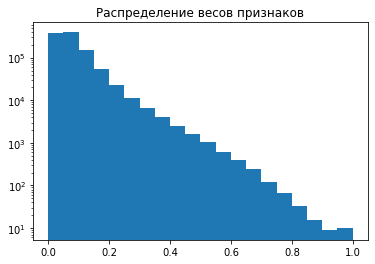

In [12]:
plt.hist(train_vectors.data, bins=20)
plt.title('Распределение весов признаков')
plt.yscale('log');

## Decision trees baseline

In [13]:
trees_clf = DecisionTreeClassifier(random_state=42)
random_clf = RandomForestClassifier(random_state=42)
gradient_clf = GradientBoostingClassifier(random_state=42)

In [14]:
trees_clf.fit(train_vectors, train_source['target'])
trees_clf.score(test_vectors, test_source['target'])

0.5293414763674986

In [15]:
random_clf .fit(train_vectors, train_source['target'])
random_clf .score(test_vectors, test_source['target'])

0.7002124269782263

In [16]:
gradient_clf .fit(train_vectors, train_source['target'])
gradient_clf .score(test_vectors, test_source['target'])

0.6818906001062135

## SVM baseline

In [17]:
svm_clf = LinearSVC(random_state=42)
svm_clf.fit(train_vectors, train_source['target'])
svm_clf.score(test_vectors, test_source['target'])

0.7266330323951142

## Logistic regression baseline

In [18]:
logistic_clf = LogisticRegression(random_state=42)
logistic_clf.fit(train_vectors, train_source['target'])
logistic_clf.score(test_vectors, test_source['target'])

0.7328730748805098

## LDA model

In [19]:
# creating dictionary by gensim
train_dic = corpora.Dictionary(train_tokens)
train_dic.filter_extremes(no_below=5, no_above=0.5)
freqs = [pair[1] for pair in train_dic.most_common(len(train_dic))]
bow = [train_dic.doc2bow(sentence) for sentence in train_tokens]

In [20]:
train_dic = corpora.Dictionary(train_tokens)
train_dic.filter_extremes(no_below=5, no_above=0.5)

In [21]:
dir(train_dic)

['__abstractmethods__',
 '__class__',
 '__contains__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__reversed__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_adapt_by_suffix',
 '_load_specials',
 '_save_specials',
 '_smart_save',
 'add_documents',
 'add_lifecycle_event',
 'cfs',
 'compactify',
 'dfs',
 'doc2bow',
 'doc2idx',
 'filter_extremes',
 'filter_n_most_frequent',
 'filter_tokens',
 'from_corpus',
 'from_documents',
 'get',
 'id2token',
 'items',
 'iteritems',
 'iterkeys',
 'itervalues',
 'keys',
 'lifecycle_events',
 'load',
 'load_from_text',
 'merge_with',
 'most_common',
 'num_docs',
 'num_nnz',
 'num_pos',
 'patch_with_special_tokens',
 '

In [22]:
# tfidf calculation
tfidf = models.TfidfModel(bow)
corpus_tfidf = tfidf[bow]

In [23]:
# lda topic modeling
lda = models.LdaModel(corpus=bow, num_topics=20, id2word=train_dic)
doc_lda = lda[bow]
#lda.show_topics(20)

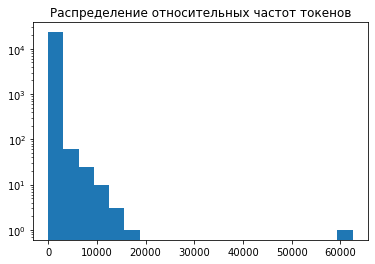

In [24]:
plt.hist(freqs, bins=20)
plt.title('Распределение относительных частот токенов')
plt.yscale('log');

## PyTorch baseline

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vocab_len = len(vocab)
target_len = len(set(train_source['target']))
emb_dim = 1000 

In [26]:
x_train = torch.tensor(scipy.sparse.csr_matrix.todense(train_vectors)).float()
x_test = torch.tensor(scipy.sparse.csr_matrix.todense(test_vectors)).float()
y_train = torch.tensor(train_source['target'])
y_test = torch.tensor(test_source['target'])

In [27]:
class NewsDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        sentence = self.x[idx]
        label = self.y[idx]
        return sentence, label

In [48]:
class TextClassificationModel(nn.Module):

    def __init__(self, vocab_size, embed_dim, num_class):
        super(TextClassificationModel,self).__init__()
        self.embedding = nn.Linear(vocab_size, embed_dim)
        self.fc = nn.Linear(embed_dim, num_class)   
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, text):
        embedded = self.embedding(text)
        out = self.fc(embedded)
        return F.log_softmax(out)

In [49]:
train_dataset = NewsDataset(x_train, y_train)
test_dataset = NewsDataset(x_test, y_test)
train_dataloader = DataLoader(train_dataset, batch_size=10, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=10, shuffle=False)

In [50]:
model = TextClassificationModel(vocab_len, emb_dim, target_len).to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

In [51]:
def train(dataloader):
    model.train()
    total_acc, total_count = 0, 0
    log_interval = 500
    epoch = 0
    start_time = time.time()

    for idx, (text, label) in enumerate(dataloader):
        optimizer.zero_grad()
        predicted_label = model(text)
        loss = criterion(predicted_label, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()
        total_acc += (predicted_label.argmax(1) == label).sum().item()
        total_count += label.size(0)
        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches '
                  '| accuracy {:8.3f}'.format(epoch, idx, len(dataloader),
                                              total_acc/total_count))
            total_acc, total_count = 0, 0
            epoch += 1

def evaluate(dataloader):
    model.eval()
    total_acc, total_count = 0, 0

    with torch.no_grad():
        for idx, (text, label) in enumerate(dataloader):
            predicted_label = model(text)
            loss = criterion(predicted_label, label)
            total_acc += (predicted_label.argmax(1) == label).sum().item()
            total_count += label.size(0)
    return total_acc/total_count

In [52]:
def train_eval_loop(train_dataloader, test_dataloader, n_epochs):  
  total_accu = None
  for epoch in range(1, n_epochs + 1):
    epoch_start_time = time.time()
    train(train_dataloader)
    accu_val = evaluate(test_dataloader)
    if total_accu is not None and total_accu > accu_val:
      scheduler.step()
    else:
       total_accu = accu_val
    print('-' * 59)
    print('| end of epoch {:3d} | time: {:5.2f}s | '
          'test accuracy {:8.3f} '.format(epoch,
                                           time.time() - epoch_start_time,
                                           accu_val))
    print('-' * 59)

In [54]:
train_eval_loop(train_dataloader, test_dataloader, 2)

<ipython-input-48-02a09e0ec718>:18: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)


RuntimeError: expected scalar type Long but found Int

In [ ]:
labels = train_source["target_names"]

In [ ]:
idx = 2
predicted_label = model.forward(x_train[idx]).argmax()
print(train_source['data'][idx])
print("-"*98)
print(labels[predicted_label])

##Pretrained models baseline

In [59]:
!pip install transformers

In [60]:
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification

In [ ]:
pret_tokenizer = AutoTokenizer.from_pretrained("valhalla/distilbart-mnli-12-1")
pret_model = AutoModelForSequenceClassification.from_pretrained("valhalla/distilbart-mnli-12-1")

In [ ]:
classifier = pipeline("zero-shot-classification", model=pret_model, tokenizer=pret_tokenizer)

In [ ]:
classifier(train_source['data'][2], labels)